<a href="https://colab.research.google.com/github/harry418/EmotionRecog/blob/master/training/training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Imported importanat libraries

In [2]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import sys
import tensorflow
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input

# load preprocessed data


In [3]:
# storing preprocessed images and labels for further use
data = np.load('/content/gdrive/My Drive/emotion_recog/data.npy')
labels_value  = np.load('/content/gdrive/My Drive/emotion_recog/labels_value.npy')

# train and test splitting with sklearn


In [4]:
trainX, testX,trainY, testY = train_test_split(data, labels_value,test_size=0.2, random_state=42,shuffle = True)

# Training and plotting accuracy and loss

In [5]:
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
	plt.show()

In [6]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D

inp = Input(shape = (224,224,3))

model_mobile = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
x1 = model_mobile(inp)
x2 = GlobalAveragePooling2D()(x1)
x3 = Dense(128,activation='relu')(x2)
out = Dense(6, activation='softmax')(x3)

INIT_LR = 1e-4
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR /100)
model = Model(inputs = inp, outputs = out)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

[INFO] compiling model...


In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 2,422,726
Trainable params: 2,388,614
Non-trainable params: 34,112
_________________________________________________________________


In [8]:
# batch size and epochs
EPOCHS = 100
BS = 32

In [9]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=BS)
# fit model
steps = int(trainX.shape[0] / BS)
hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=EPOCHS, validation_data=(testX, testY), verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
53/53 [==============================] - 21s 405ms/step - loss: 1.0168 - accuracy: 0.6065 - val_loss: 1.1758 - val_accuracy: 0.5684
Epoch 2/100
53/53 [==============================] - 21s 392ms/step - loss: 0.5162 - accuracy: 0.8278 - val_loss: 1.0956 - val_accuracy: 0.6241
Epoch 3/100
53/53 [==============================] - 21s 388ms/step - loss: 0.3258 - accuracy: 0.8947 - val_loss: 1.0293 - val_accuracy: 0.6427
Epoch 4/100
53/53 [==============================] - 21s 391ms/step - loss: 0.2194 - accuracy: 0.9325 - val_loss: 1.1885 - val_accuracy: 0.6195
Epoch 5/100
53/53 [==============================] - 21s 388ms/step - loss: 0.1385 - accuracy: 0.9580 - val_loss: 1.2249 - val_accuracy: 0.6404
Epoch 6/100
53/53 [==============================] - 21s 390ms/step - loss: 0.0931 - accuracy: 0.9764 - val_loss: 1.2620 - val_accuracy: 0.6682
Epoch 7/100
53/53 [==============================] - 21s 389

In [10]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=1)
print('> %.3f' % (acc * 100.0))

14/14 [==============================] - 1s 38ms/step - loss: 1.6604 - accuracy: 0.7796
> 77.958


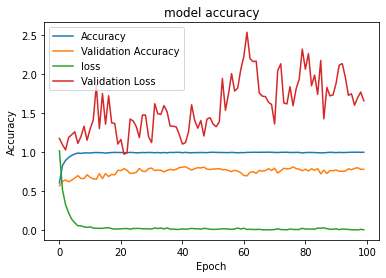

In [11]:
summarize_diagnostics(hist)

# Confusion matrix and classification report

In [15]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(testX)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(testY,axis=1)
print(confusion_matrix(y_true,y_p))

[[33  0  0  0  0  0]
 [ 1 56 14 16 10  1]
 [ 0  1 66  7  1  0]
 [ 0  0 10 74  7  0]
 [ 0  3  6 17 34  1]
 [ 0  0  0  0  0 73]]


In [16]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.93      0.57      0.71        98
           2       0.69      0.88      0.77        75
           3       0.65      0.81      0.72        91
           4       0.65      0.56      0.60        61
           5       0.97      1.00      0.99        73

    accuracy                           0.78       431
   macro avg       0.81      0.80      0.80       431
weighted avg       0.80      0.78      0.78       431



# CNN + SVM

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# extracting features using Transfer Learning
model_new = Model(inputs = model.input,outputs = model.get_layer('global_average_pooling2d').output) 
train_new = sc.fit_transform(model_new.predict(trainX))
test_new = sc.fit_transform(model_new.predict(testX))

In [24]:

from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(train_new,np.argmax(trainY,axis=1))
sc1 = svm.score(train_new,np.argmax(trainY,axis=1))
sc2 = svm.score(test_new,np.argmax(testY,axis=1))
print('training accuracy of svm is : ',sc1)
print('testing accuracy of svm is : ',sc2)

training accuracy of svm is :  1.0
testing accuracy of svm is :  0.8213457076566125


# CNN + XGBOOST


In [25]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(train_new,np.argmax(trainY,axis=1))
sc3 = xg.score(train_new,np.argmax(trainY,axis=1))
sc4 = xg.score(test_new,np.argmax(testY,axis=1))
print('training accuracy of xgboost is : ',sc3)
print('testing accuracy of xgboost is : ',sc4)

training accuracy of xgboost is :  1.0
testing accuracy of xgboost is :  0.8004640371229699
